In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyhf
import json
import logging
from pyhf import runOnePoint, hfpdf
from pyhf.simplemodels import hepdata_like

def CLsOnePoint(muTest, data, pdf, init_pars,par_bounds):
    clsobs, cls_exp = runOnePoint(muTest, data,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

In [3]:
def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

In [4]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)


/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:307: RuntimeWarning: divide by zero encountered in log
  summands = np.log(_poisson_impl(actual_data, lambdas_data))
/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:300: RuntimeWarning: divide by zero encountered in log
  summands = np.concatenate([summands,np.log(mod.pdf(thisauxdata, modalphas))])


{'exp': [1.070397565798206,
  1.4420036447647087,
  2.0195346061497648,
  2.865953837042437,
  3.9631391175146797],
 'obs': 2.3880423878562675}

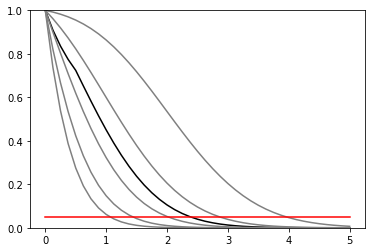

In [5]:
source = json.load(open('../../validation/data/1bin_example1.json'))
pdf  = hepdata_like(source['bindata']['sig'], source['bindata']['bkg'], source['bindata']['bkgerr'])
data = source['bindata']['data'] + pdf.auxdata

init_pars  = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

mutests = np.linspace(0,5,41)
tests = [CLsOnePoint(muTest,data,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)

In [6]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [120.0, 145.0],
    "bkg":     [100.0, 150.0],
    "bkgerr":  [15.0, 20.0],
    "sig":     [30.0, 45.0]
  }
}


my_observed_counts = source['bindata']['data']

pdf  = hepdata_like(source['bindata']['sig'], source['bindata']['bkg'], source['bindata']['bkgerr'])
data = my_observed_counts + pdf.auxdata


from pyhf import hfpdf, unconstrained_bestfit
binning = source['binning']

nompars = pdf.config.suggested_init()


bonlypars = [x for x in nompars]
bonlypars[pdf.config.poi_index] = 0.0
nom_bonly = pdf.expected_data(bonlypars, include_auxdata = False)

# print (nom_bonly)


nom_sb = pdf.expected_data(nompars, include_auxdata = False)


init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

print (init_pars)

bestfit_pars = unconstrained_bestfit(data,pdf,init_pars,par_bounds)
bestfit_cts  = pdf.expected_data(bestfit_pars, include_auxdata = False)

def plot_histo(ax, binning, data):
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]
    ax.bar(bin_centers,data,1, alpha=0.5)


def plot_data(ax, binning, data):
    errors = [math.sqrt(d) for d in data]
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]    
    ax.bar(bin_centers,data,0, yerr=errors, linewidth=0, error_kw = dict(ecolor='k', elinewidth = 1))
    ax.scatter(bin_centers, data, c = 'k')


[1.0, 1.0, 1.0]


In [7]:
init = []
for name in pdf.config.par_order:
    print(pdf.config.par_map[name]['suggested_init'])
    init = init + pdf.config.par_map[name]['suggested_init']
init


[1.0]
[1.0, 1.0]


[1.0, 1.0, 1.0]

(0, 300)

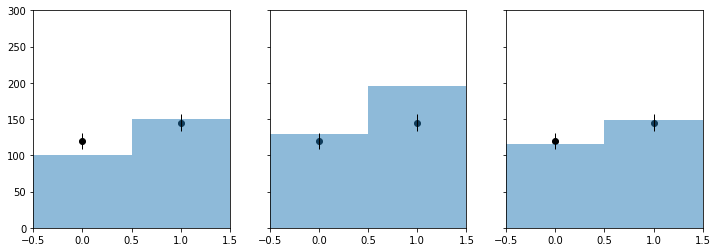

In [8]:
f,axarr = plt.subplots(1,3,sharey=True)
f.set_size_inches(12,4)

plot_histo(axarr[0], binning, nom_bonly)
plot_data(axarr[0], binning, my_observed_counts)
axarr[0].set_xlim(binning[1:])

plot_histo(axarr[1], binning, nom_sb)
plot_data(axarr[1], binning, my_observed_counts)
axarr[1].set_xlim(binning[1:])

plot_histo(axarr[2], binning, bestfit_cts)
plot_data(axarr[2], binning, my_observed_counts)
axarr[2].set_xlim(binning[1:])

plt.ylim(0,300)

In [9]:
##
##  DUMMY 2D thing
##

def signal(m1,m2):
    massscale = 150.
    minmass = 100.
    countscale = 2000
    
    effective_mass = np.sqrt(m1**2 + m2**2)
    return [countscale*np.exp(-(effective_mass-minmass)/massscale), 0]

def cls(m1,m2):
    signal_counts = signal(m1,m2)
    pdf = hepdata_like(signal_counts, source['bindata']['bkg'], source['bindata']['bkgerr'])
    clsobs, clsexp = CLsOnePoint(1.0,data,pdf,init_pars,par_bounds)[-2:]
    
    return clsobs, clsexp

In [10]:
nx, ny = 15,15
grid = grid_x, grid_y = np.mgrid[100:1000:complex(0,nx),100:1000:complex(0,ny)]
X = grid.T.reshape(nx * ny,2)
results = [cls(m1,m2) for m1,m2 in X]

/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  CLs  = CLb/CLsb


In [11]:
yobs =  [obs    for obs, exp in results]
yexp = [[exp[i] for obs, exp in results] for i in range(5)]

(15, 15)


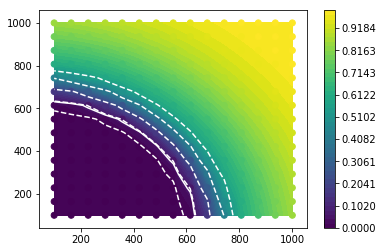

In [12]:
from scipy.interpolate import griddata
int_obs = griddata(X, yobs, (grid_x, grid_y), method='linear')

int_exp = [griddata(X, yexp[i], (grid_x, grid_y), method='linear') for i in range(5)]

print (int_obs.shape)


plt.contourf(grid_x, grid_y, int_obs, levels = np.linspace(0,1))
plt.colorbar()

plt.contour(grid_x, grid_y, int_obs, levels = [0.05], colors = 'w')
for level in int_exp:
    plt.contour(grid_x, grid_y, level, levels = [0.05], colors = 'w', linestyles = 'dashed')

plt.scatter(X[:,0],X[:,1], c = yobs, vmin = 0, vmax = 1)
